In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [3]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [4]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [6]:
# Única fila con valores nulos.
df[df["dropoff_longitude"].isna()]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,32736015,2013-07-02 03:51:57.0000001,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


In [7]:
df.duplicated().values.any()

np.False_

In [8]:
df.isna().values.any()

np.True_

In [9]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [10]:
# Función para calcular la distancia del viaje en base a las coordenadas 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [11]:
# Función para asignar la franja horaria
def obtener_franja_horaria(hora):
    if 0 <= hora <= 5:
        return 'Madrugada'
    elif 6 <= hora <= 9:
        return 'Mañana'
    elif 10 <= hora <= 15:
        return 'Mediodia/Tarde'
    elif 16 <= hora <= 19:
        return 'Tarde'
    else:
        return 'Noche'

In [12]:
# Creación de copia del df para evitar conflictos.
df_copy = df.copy()

<Axes: ylabel='fare_amount'>

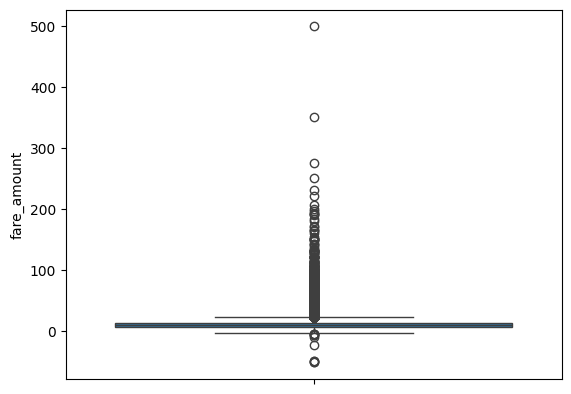

In [13]:
sns.boxplot(df_copy["fare_amount"])

In [14]:
# Eliminación de único valor atípico en la cantidad de pasajeros 
df_copy = df_copy[df_copy["passenger_count"] < 7]


In [15]:
# Filas con precios atípicos
df_copy[df_copy["fare_amount"] > 250]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4292,33491441,2014-10-24 20:20:00.000000181,350.0,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.0000,3
170081,51151143,2011-04-10 04:10:00.00000064,499.0,2011-04-10 04:10:00 UTC,-73.968377,40.764602,-73.968368,40.7646,1
185325,20013003,2013-04-19 00:00:00.000000235,275.0,2013-04-19 00:00:00 UTC,0.000000,0.000000,0.000000,0.0000,1


In [16]:
df_copy = df_copy[df_copy["fare_amount"] < 250] 

In [17]:
df_copy["fare_amount"].describe()

count    199995.000000
mean         11.353311
std           9.780229
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         230.000000
Name: fare_amount, dtype: float64

Eliminación de filas con precio negativo. 

In [18]:
df_copy = df_copy[df_copy["fare_amount"] > 0]

In [19]:
# Conversión de tipo de datos y creación de columnas. 
df_copy["passenger_count"] = df_copy["passenger_count"].astype("Int64")
df_copy["date"] = pd.to_datetime(df_copy["date"])
df_copy['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [20]:
df_copy.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [21]:
df_copy['dia_semana'] = df_copy['pickup_datetime'].dt.weekday
n = 7
df_copy["dia_sin"] = np.sin(2 * np.pi * df_copy["dia_semana"] / n)
df_copy["dia_cos"] = np.cos(2 * np.pi * df_copy["dia_semana"] / n)

In [22]:
df_copy.drop(columns=["dia_semana"], inplace=True)

In [23]:
df_copy["distance_km"] = haversine(
    df_copy["pickup_latitude"], df_copy["pickup_longitude"],
    df_copy["dropoff_latitude"], df_copy["dropoff_longitude"]
)

In [24]:
# Eliminacióin de columna redundante, igual que pickup_datetime
df_copy = df_copy.drop("date",axis=1)

In [25]:
# Aplicar la función a la columna de la hora para crear la nueva variable categórica
df_copy['franja_horaria'] = df_copy['pickup_datetime'].dt.hour.apply(obtener_franja_horaria)

In [26]:
df_copy.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,1.683323,Tarde
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,2.457590,Noche
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,5.036377,Noche
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,1.661683,Mañana
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,4.475450,Tarde


In [27]:
# Creación de dummies en columna franja horaria
encoder = OneHotEncoder(sparse_output=False, drop='first')  

encoded = encoder.fit_transform(df_copy[['franja_horaria']])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['franja_horaria']))

df_encoded = pd.concat([df_copy.drop(columns=['franja_horaria']), encoded_df], axis=1)

df_encoded.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde
0,24238194.0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,1.683323,0.0,0.0,0.0,1.0
1,27835199.0,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,2.457590,0.0,0.0,1.0,0.0
2,44984355.0,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,5.036377,0.0,0.0,1.0,0.0
3,25894730.0,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,1.661683,1.0,0.0,0.0,0.0
4,17610152.0,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,4.475450,0.0,0.0,0.0,1.0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop(columns='fare_amount'), df_copy['fare_amount'], test_size=0.2, random_state=42)

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159978 entries, 110737 to 121972
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                159978 non-null  int64              
 1   pickup_datetime    159978 non-null  datetime64[ns, UTC]
 2   pickup_longitude   159978 non-null  float64            
 3   pickup_latitude    159978 non-null  float64            
 4   dropoff_longitude  159977 non-null  float64            
 5   dropoff_latitude   159977 non-null  float64            
 6   passenger_count    159978 non-null  Int64              
 7   dia_sin            159978 non-null  float64            
 8   dia_cos            159978 non-null  float64            
 9   distance_km        159977 non-null  float64            
 10  franja_horaria     159978 non-null  object             
dtypes: Int64(1), datetime64[ns, UTC](1), float64(7), int64(1), object(1)
memory usage: 14.8+ MB

In [30]:
# Eliminación de única fila con nulos
X_train.dropna(inplace=True)

In [31]:
X_train.sample(10)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
166177,16228312,2009-01-07 19:30:56+00:00,-73.963019,40.758486,-73.968321,40.786555,2,0.974928,-0.222521,3.152903,Tarde
21113,28841326,2009-05-18 16:55:48+00:00,-73.981079,40.784423,-73.952369,40.784772,3,0.000000,1.000000,2.417508,Tarde
13605,37349893,2013-06-09 00:56:09+00:00,-73.940951,40.722036,-73.972298,40.796362,2,-0.781831,0.623490,8.676152,Madrugada
195399,46587453,2014-04-03 03:02:37+00:00,-73.884821,40.738414,-73.773944,40.679878,1,0.433884,-0.900969,11.388959,Madrugada
155145,8298438,2014-11-14 10:08:00+00:00,-73.987263,40.744285,-73.986277,40.751847,1,-0.433884,-0.900969,0.844948,Mediodia/Tarde
130727,19602540,2014-10-31 15:33:00+00:00,-73.960652,40.801505,-73.956242,40.778142,1,-0.433884,-0.900969,2.624242,Mediodia/Tarde
62206,30372894,2014-12-22 23:23:00+00:00,-73.987413,40.756472,-73.996657,40.760317,1,0.000000,1.000000,0.888257,Noche
136274,12002707,2014-12-13 06:31:10+00:00,-73.978214,40.761795,-73.788949,40.647265,1,-0.974928,-0.222521,20.413639,Mañana
24176,53102094,2015-02-25 15:03:04+00:00,-73.998032,40.721199,-73.970680,40.764038,1,0.974928,-0.222521,5.291543,Mediodia/Tarde
133028,48309830,2010-08-16 17:25:00+00:00,-73.988058,40.779517,-73.982153,40.771470,2,0.000000,1.000000,1.023660,Tarde


In [32]:
X_train[X_train["distance_km"] == 0]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
139465,161410,2009-07-03 17:14:00+00:00,-73.962650,40.766882,-73.962650,40.766882,1,-0.433884,-0.900969,0.0,Tarde
154531,45001200,2011-04-16 16:59:00+00:00,0.000000,0.000000,0.000000,0.000000,2,-0.974928,-0.222521,0.0,Tarde
198104,26269623,2010-08-04 08:14:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0.974928,-0.222521,0.0,Mañana
157889,34753900,2015-06-24 13:40:44+00:00,0.000000,0.000000,0.000000,0.000000,1,0.974928,-0.222521,0.0,Mediodia/Tarde
190105,3353914,2009-03-17 07:40:04+00:00,0.000000,0.000000,0.000000,0.000000,1,0.781831,0.623490,0.0,Mañana
...,...,...,...,...,...,...,...,...,...,...,...
12667,50739849,2009-03-06 13:13:41+00:00,0.000000,0.000000,0.000000,0.000000,1,-0.433884,-0.900969,0.0,Mediodia/Tarde
124389,46970688,2014-11-12 17:52:11+00:00,0.000000,0.000000,0.000000,0.000000,1,0.974928,-0.222521,0.0,Tarde
139658,10670628,2013-05-27 21:16:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0.000000,1.000000,0.0,Noche
197656,8665170,2012-04-09 17:43:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0.000000,1.000000,0.0,Tarde


In [33]:
# Valores atípicos pero posibles dentro de NY y en sus cercanías
X_train[(X_train["distance_km"] > 150) & (X_train["distance_km"] < 250)]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
24751,1200661,2011-02-17 18:30:35+00:00,-75.426904,40.774075,-73.971779,39.622013,1,0.433884,-0.900969,177.995633,Tarde
197483,34261866,2011-05-09 13:41:53+00:00,-75.342288,40.646767,-73.976186,39.615770,1,0.000000,1.000000,163.187094,Mediodia/Tarde


In [34]:
X_train[(X_train["distance_km"] > 250)]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
51267,50575899,2011-08-19 01:39:01+00:00,0.000000,0.000000,-73.935500,40.688100,2,-0.433884,-0.900969,8660.720873,Madrugada
96283,3073085,2015-03-20 22:35:58+00:00,0.000000,0.000000,-73.963203,40.774052,2,-0.433884,-0.900969,8664.778514,Noche
122550,18418425,2013-05-16 08:08:09+00:00,-73.977080,40.751393,0.000000,0.000000,1,0.433884,-0.900969,8665.462639,Mañana
64384,16831885,2012-02-23 15:10:00+00:00,-0.116667,40.746217,0.000000,0.000000,1,0.433884,-0.900969,4530.787941,Mediodia/Tarde
190403,51951653,2014-06-08 14:49:00+00:00,-74.013237,40.717422,0.000000,0.000000,1,-0.781831,0.623490,8667.762148,Mediodia/Tarde
...,...,...,...,...,...,...,...,...,...,...,...
35740,46898673,2013-11-06 16:50:08+00:00,-73.987819,40.738399,0.000000,0.000000,1,0.974928,-0.222521,8666.085761,Tarde
154800,16463213,2015-06-15 08:07:41+00:00,-73.996712,40.733402,0.000000,0.000000,1,0.000000,1.000000,8666.719980,Mañana
58246,13199504,2013-08-26 18:04:00+00:00,-73.947277,40.805427,0.000000,40.802898,1,0.000000,1.000000,6022.748042,Tarde
118338,47829179,2012-10-09 07:56:00+00:00,-74.004672,40.746927,0.000000,40.774267,2,0.781831,0.623490,6031.361768,Mañana


In [35]:
coords = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
conteo_ceros = (df_copy[coords] == 0.0).sum(axis=1)
df_filtrado = df_copy[conteo_ceros > 2]
df_filtrado

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
7,44195482,2.5,2012-12-11 13:52:00+00:00,0.0,0.0,0.0,0.0,1,0.781831,0.623490,0.0,Mediodia/Tarde
11,6379048,8.5,2011-05-23 22:15:00+00:00,0.0,0.0,0.0,0.0,1,0.000000,1.000000,0.0,Noche
65,21993993,6.0,2014-05-05 19:27:00+00:00,0.0,0.0,0.0,0.0,1,0.000000,1.000000,0.0,Tarde
92,1454546,6.1,2011-12-02 14:07:00+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Mediodia/Tarde
120,17358122,6.5,2010-08-20 19:39:48+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Tarde
...,...,...,...,...,...,...,...,...,...,...,...,...
199718,49162936,4.9,2011-08-19 07:16:00+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Mañana
199724,46007628,7.5,2013-10-11 11:25:41+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Mediodia/Tarde
199880,35013970,6.5,2014-02-22 06:45:46+00:00,0.0,0.0,0.0,0.0,1,-0.974928,-0.222521,0.0,Mañana
199883,44115598,12.5,2012-09-10 17:39:00+00:00,0.0,0.0,0.0,0.0,2,0.000000,1.000000,0.0,Tarde


In [36]:
# Conversión de atípico a Nan para imputación futura 
X_train.loc[(X_train["distance_km"] > 250) | (X_train["distance_km"] == 0), "distance_km"] = np.nan

In [37]:
X_train.loc[X_train["passenger_count"] == 0, "passenger_count"] = np.nan

In [38]:
X_train.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dia_sin',
       'dia_cos', 'distance_km', 'franja_horaria'],
      dtype='object')

In [39]:
[c for c in X_train.columns if c != "pickup_datetime"]

['key',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'dia_sin',
 'dia_cos',
 'distance_km',
 'franja_horaria']

In [ ]:
from sklearn.impute import KNNImputer


# Seleccionamos las columnas numéricas que queremos imputar
cols_to_impute = ["distance_km", "passenger_count"]

# Instanciamos el imputador
knn_imputer = KNNImputer(n_neighbors=5)

# Ajustamos y transformamos solo esas columnas
imputed = knn_imputer.fit_transform(X_train[cols_to_impute])

# Pasamos de nuevo a DataFrame
X_train[cols_to_impute] = pd.DataFrame(imputed, columns=cols_to_impute, index=X_train.index)



DataFrame después de la imputación:


In [63]:
X_train["passenger_count"] = round(X_train["passenger_count"]).astype("Int64")

In [65]:
X_train["passenger_count"].value_counts()

passenger_count
1    110990
2     23693
5     11222
3      7210
6      3455
4      3407
Name: count, dtype: Int64

In [64]:
X_train["passenger_count"]

110737    1
4252      1
112646    1
100778    1
175699    2
         ..
119893    1
103705    1
131946    1
146882    1
121972    1
Name: passenger_count, Length: 159977, dtype: Int64

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159977 entries, 110737 to 121972
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                159977 non-null  int64              
 1   pickup_datetime    159977 non-null  datetime64[ns, UTC]
 2   pickup_longitude   159977 non-null  float64            
 3   pickup_latitude    159977 non-null  float64            
 4   dropoff_longitude  159977 non-null  float64            
 5   dropoff_latitude   159977 non-null  float64            
 6   passenger_count    159977 non-null  float64            
 7   dia_sin            159977 non-null  float64            
 8   dia_cos            159977 non-null  float64            
 9   distance_km        159977 non-null  float64            
 10  franja_horaria     159977 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(8), int64(1), object(1)
memory usage: 14.6+ MB


In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159977 entries, 110737 to 121972
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                159977 non-null  int64              
 1   pickup_datetime    159977 non-null  datetime64[ns, UTC]
 2   pickup_longitude   159977 non-null  float64            
 3   pickup_latitude    159977 non-null  float64            
 4   dropoff_longitude  159977 non-null  float64            
 5   dropoff_latitude   159977 non-null  float64            
 6   passenger_count    159977 non-null  float64            
 7   dia_sin            159977 non-null  float64            
 8   dia_cos            159977 non-null  float64            
 9   distance_km        159977 non-null  float64            
 10  franja_horaria     159977 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(8), int64(1), object(1)
memory usage: 14.6+ MB


In [43]:
X_train.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dia_sin',
       'dia_cos', 'distance_km', 'franja_horaria'],
      dtype='object')

In [44]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km
count,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000
mean,-72.525400,39.936535,-72.540628,39.932828,1.690830,-0.001825,-0.042737,3.356103
std,11.158298,7.424775,13.352090,6.550333,1.305692,0.711576,0.701310,3.984652
min,-1340.648410,-74.015515,-3356.666300,-74.015750,1.000000,-0.974928,-0.900969,0.000084
25%,-73.992064,40.734805,-73.991403,40.733756,1.000000,-0.781831,-0.900969,1.303970
50%,-73.981842,40.752575,-73.980111,40.753058,1.000000,0.000000,-0.222521,2.227856
75%,-73.967191,40.767160,-73.963727,40.768038,2.000000,0.781831,0.623490,3.850010
max,40.808425,1644.421482,40.828672,872.697628,6.000000,0.974928,1.000000,177.995633


In [45]:
# valores raros en cantidad de pasajeros 
X_train[X_train["passenger_count"] > 5]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
126280,39285896,2011-10-15 13:00:00+00:00,-73.991313,40.723867,-73.998270,40.726040,6.0,-0.974928,-0.222521,0.634101,Mediodia/Tarde
119309,35454642,2014-05-15 08:51:00+00:00,-74.009490,40.718742,-73.983485,40.758212,6.0,0.433884,-0.900969,4.905353,Mañana
161637,53852588,2015-06-08 21:21:25+00:00,-73.985397,40.747219,-73.999680,40.730869,6.0,0.000000,1.000000,2.180159,Noche
81361,28522620,2014-12-29 20:05:00+00:00,-73.972160,40.793950,-73.968950,40.788580,6.0,0.000000,1.000000,0.655420,Noche
136805,33902508,2014-04-20 03:10:00+00:00,-73.995012,40.764425,-73.939157,40.752187,6.0,-0.781831,0.623490,4.897349,Madrugada
...,...,...,...,...,...,...,...,...,...,...,...
183179,25443982,2015-04-04 12:18:35+00:00,-73.954086,40.790287,-73.981300,40.784248,6.0,-0.974928,-0.222521,2.387522,Mediodia/Tarde
93436,49071202,2013-07-12 21:29:00+00:00,-74.001742,40.735327,-73.985133,40.741612,6.0,-0.433884,-0.900969,1.564149,Noche
113583,23602161,2012-07-19 23:17:00+00:00,-73.975222,40.761115,-73.971285,40.680927,6.0,0.433884,-0.900969,8.922670,Noche
2568,11585668,2012-04-07 23:11:00+00:00,-73.985683,40.731365,-73.992953,40.724337,6.0,-0.974928,-0.222521,0.992975,Noche


In [46]:
# Valores raros en columna de precios 
y_train[y_train > 150]

131093    150.83
114282    190.83
105806    165.33
90818     163.00
53996     171.35
127214    183.00
145249    160.00
23682     206.38
33911     192.33
188234    165.00
184901    196.00
45094     170.00
18415     190.00
39716     191.80
197493    230.00
196647    200.00
19509     180.00
Name: fare_amount, dtype: float64

In [47]:
# Valores atípicos en distancia(valores faltantes en lat/long)
X_train[X_train["distance_km"] > 60]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria
21353,33456163,2010-05-03 11:45:32+00:00,-73.137393,41.366138,-74.006791,40.728763,1.0,0.000000,1.000000,101.676953,Mediodia/Tarde
79244,33480288,2009-07-14 10:19:06+00:00,-73.137393,41.366138,-73.988598,40.757339,1.0,0.781831,0.623490,98.364525,Mediodia/Tarde
186417,26659125,2009-11-08 01:18:22+00:00,-73.137393,41.366138,-73.991252,40.750145,2.0,-0.781831,0.623490,99.080212,Madrugada
101692,53752103,2009-05-19 16:53:43+00:00,-73.985779,40.758935,-73.137393,41.366138,1.0,0.781831,0.623490,98.070305,Tarde
94734,44686129,2011-03-04 15:08:06+00:00,-73.969908,40.762523,-73.952284,39.614156,1.0,-0.433884,-0.900969,127.701329,Mediodia/Tarde
113021,17184298,2011-05-05 07:15:20+00:00,-73.986632,40.761410,-75.423067,40.773931,2.0,0.433884,-0.900969,120.975971,Mañana
97989,15614249,2009-04-19 22:40:53+00:00,-73.984003,40.743455,-73.137393,41.366138,4.0,-0.781831,0.623490,99.162509,Noche
174237,22017671,2010-07-26 13:14:00+00:00,-73.137393,41.366138,-74.000893,40.762720,1.0,0.000000,1.000000,98.705066,Mediodia/Tarde
101247,53937050,2011-03-29 10:42:28+00:00,-73.978697,40.777357,-73.962233,39.603429,1.0,0.781831,0.623490,130.542399,Mediodia/Tarde
56185,22173897,2009-04-22 19:30:59+00:00,-73.137393,41.366138,-73.955553,40.776658,1.0,0.974928,-0.222521,94.869531,Tarde


<Axes: xlabel='distance_km', ylabel='Count'>

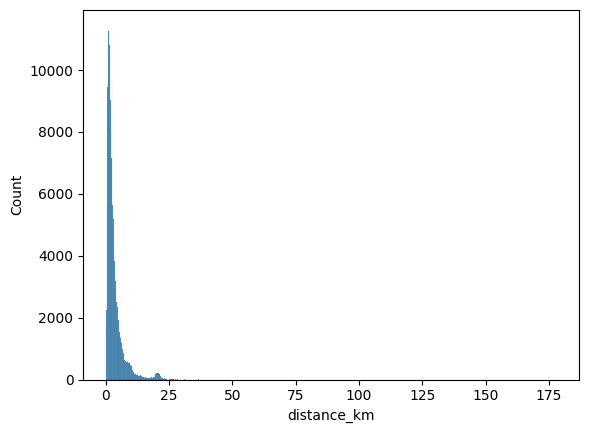

In [48]:
sns.histplot(X_train["distance_km"])

In [57]:
X_train["passenger_count"].value_counts()

passenger_count
1.000000    110819
2.000000     23509
5.000000     11222
3.000000      7170
6.000000      3455
4.000000      3402
1.200000        99
1.400000        72
1.800000        59
1.600000        47
2.200000        41
2.400000        20
2.600000        17
1.690874        17
2.800000        14
3.200000         7
3.600000         3
3.800000         2
3.400000         2
Name: count, dtype: int64

<Axes: xlabel='passenger_count', ylabel='Count'>

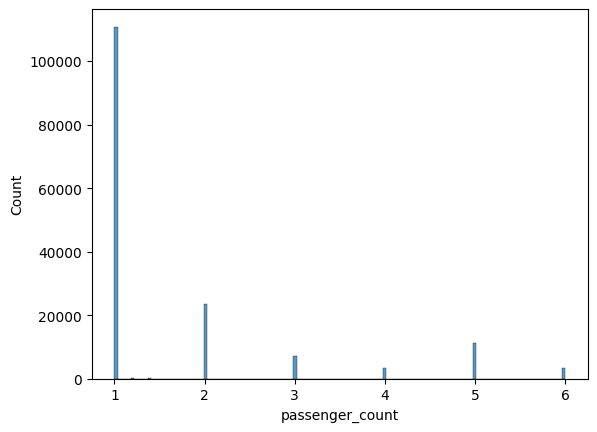

In [49]:
sns.histplot(X_train["passenger_count"])

<Axes: xlabel='distance_km', ylabel='Count'>

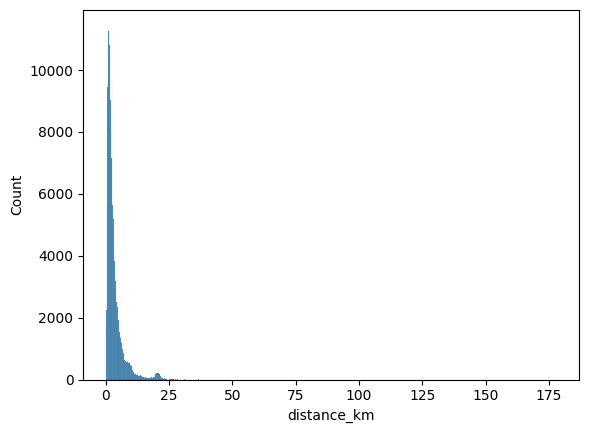

In [50]:
sns.histplot(X_train[X_train["distance_km"] > 0]["distance_km"])

In [51]:
X_train.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dia_sin',
       'dia_cos', 'distance_km', 'franja_horaria'],
      dtype='object')

Observar luego de la imputación de datos atípicos. 

In [52]:
#sns.heatmap(df_copy[["fare_amount","passenger_count","distance_km"]].corr(),vmax=1,vmin=-1,annot=True)

In [53]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km
count,1.599770e+05,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000,159977.000000
mean,2.772171e+07,-72.525400,39.936535,-72.540628,39.932828,1.690830,-0.001825,-0.042737,3.356103
std,1.600440e+07,11.158298,7.424775,13.352090,6.550333,1.305692,0.711576,0.701310,3.984652
min,1.000000e+00,-1340.648410,-74.015515,-3356.666300,-74.015750,1.000000,-0.974928,-0.900969,0.000084
25%,1.385586e+07,-73.992064,40.734805,-73.991403,40.733756,1.000000,-0.781831,-0.900969,1.303970
50%,2.776749e+07,-73.981842,40.752575,-73.980111,40.753058,1.000000,0.000000,-0.222521,2.227856
75%,4.155564e+07,-73.967191,40.767160,-73.963727,40.768038,2.000000,0.781831,0.623490,3.850010
max,5.542357e+07,40.808425,1644.421482,40.828672,872.697628,6.000000,0.974928,1.000000,177.995633


In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159977 entries, 110737 to 121972
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                159977 non-null  int64              
 1   pickup_datetime    159977 non-null  datetime64[ns, UTC]
 2   pickup_longitude   159977 non-null  float64            
 3   pickup_latitude    159977 non-null  float64            
 4   dropoff_longitude  159977 non-null  float64            
 5   dropoff_latitude   159977 non-null  float64            
 6   passenger_count    159977 non-null  float64            
 7   dia_sin            159977 non-null  float64            
 8   dia_cos            159977 non-null  float64            
 9   distance_km        159977 non-null  float64            
 10  franja_horaria     159977 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(8), int64(1), object(1)
memory usage: 14.6+ MB


In [55]:
X_train.shape[0],X_test.shape[0]

(159977, 39995)

In [56]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 159977 entries, 110737 to 121972
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                159977 non-null  int64              
 1   pickup_datetime    159977 non-null  datetime64[ns, UTC]
 2   pickup_longitude   159977 non-null  float64            
 3   pickup_latitude    159977 non-null  float64            
 4   dropoff_longitude  159977 non-null  float64            
 5   dropoff_latitude   159977 non-null  float64            
 6   passenger_count    159977 non-null  float64            
 7   dia_sin            159977 non-null  float64            
 8   dia_cos            159977 non-null  float64            
 9   distance_km        159977 non-null  float64            
 10  franja_horaria     159977 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(8), int64(1), object(1)
memory usage: 14.6+ MB
None
